In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.saving import register_keras_serializable
import gym
import procgen
import numpy as np
import os
import matplotlib.pyplot as plt
#from datetime import datetime

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed) 

Model Architecture

In [2]:
class Block(layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = layers.Conv2D(filters = filters, kernel_size = 3, strides = (1,1), activation = 'relu', padding = 'same')#, data_format = 'channels_last')
        self.conv2 = layers.Conv2D(filters = filters, kernel_size = 3, strides = (1,1), activation = 'relu', padding = 'same')#, data_format = 'channels_last')
        self.batch1 = layers.BatchNormalization()
        self.batch2 = layers.BatchNormalization()
    
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.batch1(x)
        x = self.conv2(x)
        x = self.batch2(x)
        return x + inputs   #residual connection


@register_keras_serializable()
class Model(tf.keras.Model):
    def __init__(self, action_space, input_shape, **kwargs):
        super().__init__(**kwargs)
        self.action_space = action_space
        self.input_shape = input_shape
        
        self.l = layers.Lambda(lambda s: tf.cast(s, tf.float32)/255.)
        
        self.conv1 = layers.Conv2D(filters = 16, kernel_size = 3, strides = (1,1), padding = 'same') #,data_format = 'channels_last')
        self.pooling1 = layers.MaxPooling2D(pool_size = (3, 3), strides = 2)
        self.block1 = Block(16)
        self.block2 = Block(16)
        
        self.conv2 = layers.Conv2D(filters = 32, kernel_size = 3, strides = (1,1), padding = 'same')#, data_format = 'channels_last')
        self.pooling2 = layers.MaxPooling2D(pool_size = (3, 3), strides = 2)
        self.block3 = Block(32)
        self.block4 = Block(32)
        
        self.conv3 = layers.Conv2D(filters = 32, kernel_size = 3, strides = (1,1), padding = 'same')#, data_format = 'channels_last')
        self.pooling3 = layers.MaxPooling2D(pool_size = (3, 3), strides = 2)
        self.block5 = Block(32)
        self.block6 = Block(32)
        self.relu = layers.ReLU()
        self.f = layers.Flatten()
        self.d = layers.Dense(256, activation = 'relu')
        
        self.actor_head = layers.Dense(self.action_space)
        self.critic_head = layers.Dense(1)

    def call(self, inputs):
        
        x = self.l(inputs)
        
        x = self.conv1(x)
        x = self.pooling1(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.conv2(x)
        x = self.pooling2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.conv3(x)
        x = self.pooling3(x)
        x = self.block5(x)
        x = self.block6(x)
        
        x = self.relu(x)
        x = self.f(x)
        x = self.d(x)
        
        actor_out = self.actor_head(x)
        
        critic_out = self.critic_head(x)
        
        return [actor_out, critic_out]
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'action_space': self.action_space,
            'input_shape': self.input_shape
        })
        return config

A2C Agent Class

In [3]:
class Agent():
    
    def __init__(self, env, game, max_timesteps, batch_size, entropy_coef, optimizer):    
                   
        self.train_env = env
        self.game = game
        self.Tmax = max_timesteps
        self.batch_size = batch_size
        self.entropy_coef = entropy_coef
        self.T = 0
        self.optimizer = optimizer
        self.gamma = 0.9
        self.tau = 0.95
        self.action_space = self.train_env.action_space.n
        self.observation_space = self.train_env.observation_space.shape
        
        self.model = Model(self.action_space, self.observation_space)        
        
        self.save_path = 'models'
        if not os.path.exists(self.save_path):
            os.makedirs(self.save_path)
            
        """ self.log_dir = 'logs/gradient_tape/' + datetime.now().strftime('%Y%m%d-%H%M%S')
        if not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir)
        self.summary_writer = tf.summary.create_file_writer(self.log_dir) """
            
    def save(self, model_name):
        self.model.save(os.path.join(self.save_path,model_name))
        
    def load(self, model_name):
        self.model = models.load_model(os.path.join(self.save_path,model_name))#compile=False
          
    def choose_action(self, state):
        
        logits, value = self.model(state)
        probs = tf.nn.softmax(logits)
        
        action = tf.random.categorical(logits, 1)[0,0]
        
        return action, value, probs
                 
    def compute_returns_and_gae(self, rewards, values):  
        
        returns = []
        rewards = tf.cast(rewards, dtype = tf.float32)  
        gae = 0
        next_value = 0

        for i in reversed(range(len(rewards))):
            td = rewards[i] + self.gamma * next_value - values[i] 
            gae = td + gae * self.gamma * self.tau 
            returns.insert(0, gae + values[i])
            next_value = values[i]                
        
        returns = tf.cast(returns, dtype = tf.float32)
          
        return returns
    
    def compute_entropy(self, probs):
        
        return -tf.reduce_sum(probs * tf.math.log(probs + 1e-8), axis = -1)
    
                           
    def update(self, states, actions, returns):
        
        
        with tf.GradientTape() as tape:
            
                
            actions_logits, values = self.model(states)
            actions_probs = tf.nn.softmax(actions_logits)  
              
            selected_action_probs = tf.gather_nd(actions_probs, tf.expand_dims(actions, axis=-1), batch_dims=1)
            
            
            advantages = returns - values
            advantages = (advantages - tf.reduce_mean(advantages)) / (tf.math.reduce_std(advantages) + 1e-8)            
            
            entropies = self.compute_entropy(actions_probs)
            
            actor_loss = -tf.reduce_mean(tf.math.log(selected_action_probs + 1e-8) * advantages) - tf.reduce_mean(self.entropy_coef * entropies)    
            print('actor loss', actor_loss)  


            c_loss = losses.MeanSquaredError()
            critic_loss = c_loss(returns, values)
            
            tot_loss = actor_loss + 0.5 * critic_loss 
            print('critic loss', critic_loss)
        

        grads = tape.gradient(tot_loss, self.model.trainable_variables)
        grads_and_vars = [(g, v) for g, v in zip(grads, self.model.trainable_variables) if g is not None]
    
        grads, _ = tf.clip_by_global_norm([g for g, _ in grads_and_vars], 0.5)
        print(self.T)
        self.optimizer.apply_gradients(grads_and_vars)
               
        return actor_loss, critic_loss
    
    def episode(self, state):
            
            rewards = []
            states = []
            values = []
            actions = []
              
            done = False  
            state = tf.constant(state, dtype = tf.float32)
            
            while not done :  
                
                state = tf.expand_dims(state, 0)
                
                
                action, value, _ = self.choose_action(state)
                
                state = tf.squeeze(state)
                states.append(state)
                values.append(value)
                actions.append(action)
                
                next_state, reward, done, _ = self.train_env.step(action)
                next_state = tf.constant(next_state, dtype = tf.float32)
                rewards.append(reward)
                
                self.T += 1 
                state = next_state
                
    
            values = tf.cast(values, tf.float32)  
            states = tf.cast(states, tf.float32)
            actions = tf.cast(actions, tf.int32)            
            
            return states, actions, values, rewards
            
                    
    def run(self):
        
                             
        while self.T < self.Tmax:
                
            state = self.train_env.reset()
            
            states, actions, values, rewards = self.episode(state)
            print('rewards per episode: ', tf.reduce_sum(rewards))
            
            returns = self.compute_returns_and_gae(rewards, values)
            
            dataset = tf.data.Dataset.from_tensor_slices((states, actions, returns))
            dataset = dataset.batch(self.batch_size)
            
            for states_batch, action_batch, ret_batch in dataset:
                a_loss, c_loss = self.update(states_batch, action_batch, ret_batch) 
            
            #with self.summary_writer.as_default():
             #   tf.summary.scalar('actor_loss', a_loss, step = episode)
              #  tf.summary.scalar('c_loss', c_loss, step = episode)
               # tf.summary.scalar('rewards', tf.reduce_sum(rewards), step = episode) 
                             
        self.train_env.close()
        
    def test(self, num_timesteps, seed, game, random = False):
        
        test_env = gym.make('procgen:procgen-'+game+'-v0', start_level = seed, rand_seed = seed, distribution_mode='easy', use_backgrounds = False, render_mode = 'human')

        if not random :
            self.load('a2c_'+game+'.keras')
            print('Agent Performance')
        
        else: 
            print('Random Performance')
            
        rewards= []
        timestep = 0
        cumulative_reward = 0
        
        while timestep < num_timesteps:
                     
            state = test_env.reset()
            state = tf.constant(state, dtype = tf.float32)
            done = False
            
            
            while not done:     
                
                state = tf.expand_dims(state, 0)
                
                if random: 
                    state, reward, done, _= test_env.step(test_env.action_space.sample())
                    
                else: 
                    logits, _ = self.model(state)
                    action = tf.random.categorical(logits, 1)
                    action = tf.squeeze(action)
                
                    state, reward, done, _ = test_env.step(action)
                                  
                
    
                rewards.append(reward)
                cumulative_reward += reward
                timestep += 1
                
                if (timestep >= num_timesteps):
                    break
                        
            print(f'Cumulative reward after {timestep} timesteps: {cumulative_reward}')
                             
        
        test_env.close()
        
        cum_rewards = np.cumsum(rewards)# / np.arange(1, len(rewards)+ 1)
        plt.plot(np.arange(1, len(cum_rewards) + 1), cum_rewards)
        
        plt.title(f'Cumulative reward over {len(cum_rewards)} timesteps')
        plt.xlabel('Timestep')
        plt.ylabel('Cumulative reward')
        return cum_rewards
        
    
    def plot_mean_rewards(self, agent_rewards, random_rewards):
        
        plt.plot(np.arange(1, len(agent_rewards) + 1), agent_rewards, label = 'Agent')
        plt.plot(np.arange(1, len(random_rewards) + 1), random_rewards, label = 'Random')
        plt.title(f'Cumulative reward over {len(agent_rewards)} timesteps')
        plt.xlabel('Timestep')
        plt.ylabel('Cumulative reward')
        plt.legend()
        plt.savefig(f'{self.game}.png')
    

Game: Coinrun

In [4]:
game = 'coinrun'
tot_timesteps = 20000
lr_schedule = optimizers.schedules.PolynomialDecay(initial_learning_rate = 7e-6, decay_steps = tot_timesteps, end_learning_rate = 0.0, power = 1.0)
optimizer = optimizers.RMSprop(learning_rate = lr_schedule, centered = False)
batch_size = 500
entropy_coef = 0.05

env = gym.make('procgen:procgen-'+game+'-v0', num_levels=200, start_level=seed, rand_seed=seed, distribution_mode='easy', use_backgrounds = False, render_mode = None)
agent = Agent(env, game, tot_timesteps, batch_size, entropy_coef, optimizer)

In [ ]:
agent.run()
agent.save(f'a2c_{game}.keras')


Agent Performance
Cumulative reward after 82 timesteps: 10.0
Cumulative reward after 483 timesteps: 10.0
Cumulative reward after 609 timesteps: 20.0
Cumulative reward after 696 timesteps: 20.0
Cumulative reward after 790 timesteps: 20.0
Cumulative reward after 839 timesteps: 30.0
Cumulative reward after 897 timesteps: 30.0
Cumulative reward after 987 timesteps: 40.0
Cumulative reward after 1115 timesteps: 40.0
Cumulative reward after 1187 timesteps: 40.0
Cumulative reward after 1316 timesteps: 40.0
Cumulative reward after 1367 timesteps: 40.0
Cumulative reward after 1443 timesteps: 40.0
Cumulative reward after 1625 timesteps: 40.0
Cumulative reward after 1694 timesteps: 50.0
Cumulative reward after 1750 timesteps: 60.0
Cumulative reward after 1897 timesteps: 60.0
Cumulative reward after 1966 timesteps: 70.0
Cumulative reward after 2037 timesteps: 70.0
Cumulative reward after 2115 timesteps: 80.0
Cumulative reward after 2276 timesteps: 90.0
Cumulative reward after 2539 timesteps: 90.0


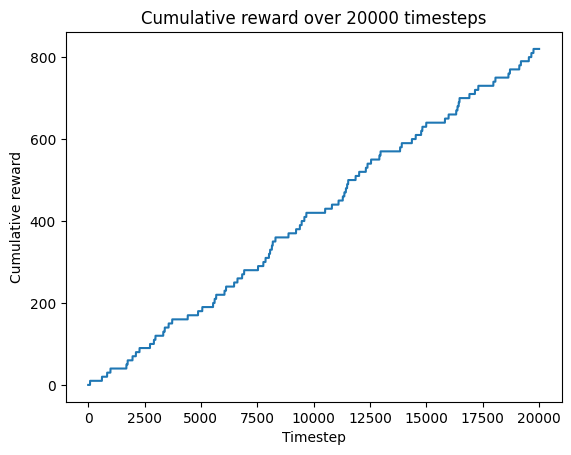

In [6]:
agent_rewards = agent.test(20000, seed, game)

Game: Maze

In [4]:
game = 'maze'
tot_timesteps = 20000 
lr_schedule = optimizers.schedules.PolynomialDecay(initial_learning_rate = 7e-6, decay_steps = tot_timesteps, end_learning_rate = 0.0, power = 1.0)
optimizer = optimizers.RMSprop(learning_rate = lr_schedule, centered = False)
batch_size = 500
entropy_coef = 0.05

 
env = gym.make('procgen:procgen-'+game+'-v0', num_levels=200, start_level=seed, rand_seed=seed, distribution_mode='easy', use_backgrounds = False, render_mode = None)
agent = Agent(env, game, tot_timesteps, batch_size, entropy_coef, optimizer)

In [ ]:
agent.run()
agent.save(f'a2c_{game}.keras')


Agent Performance
Cumulative reward after 147 timesteps: 10.0
Cumulative reward after 168 timesteps: 20.0
Cumulative reward after 668 timesteps: 20.0
Cumulative reward after 681 timesteps: 30.0
Cumulative reward after 1181 timesteps: 30.0
Cumulative reward after 1681 timesteps: 30.0
Cumulative reward after 2181 timesteps: 30.0
Cumulative reward after 2681 timesteps: 30.0
Cumulative reward after 3181 timesteps: 30.0
Cumulative reward after 3681 timesteps: 30.0
Cumulative reward after 3762 timesteps: 40.0
Cumulative reward after 3784 timesteps: 50.0
Cumulative reward after 4284 timesteps: 50.0
Cumulative reward after 4784 timesteps: 50.0
Cumulative reward after 5284 timesteps: 50.0
Cumulative reward after 5784 timesteps: 50.0
Cumulative reward after 6284 timesteps: 50.0
Cumulative reward after 6784 timesteps: 50.0
Cumulative reward after 6903 timesteps: 60.0
Cumulative reward after 7403 timesteps: 60.0
Cumulative reward after 7903 timesteps: 60.0
Cumulative reward after 8403 timesteps: 

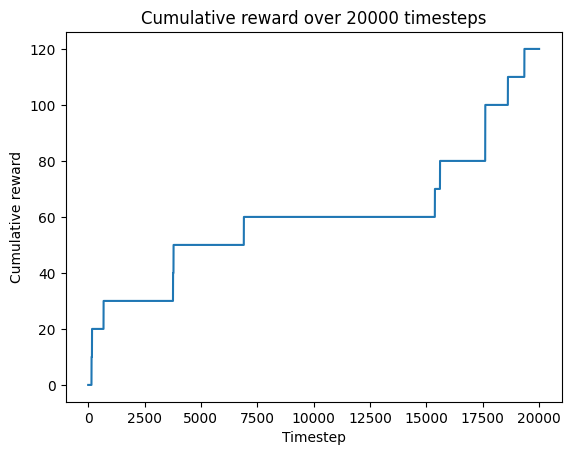

In [6]:
agent_rewards = agent.test(20000, seed, game)